In [15]:
from __future__ import print_function

import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

import random

BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
pd.options.display.max_colwidth = 100


In [2]:
import boto3
import pandas as pd
import io
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='wework-data-tensorflow', Key='MemberNotes/Wework cm notes - Notes.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.rename(columns={'[HEAT] Category': 'category'}, inplace=True)
df_mul=df[df['category'].str.contains(",")].reset_index(drop=True)
df_uni=df[~df['category'].str.contains(",")][['note_text','category']].reset_index(drop=True)
print(df_mul.shape)
print(df_uni.shape)
print(df.shape)

(6479, 4)
(20698, 2)
(27177, 4)


In [3]:
df_uni.loc[df_uni.category=='Non-English','category']='Non-English/Non-English'
df_uni.loc[df_uni.category=='Other','category']='Other/Other'
df_uni['cat_id']=df_uni.category.astype('category').cat.codes

In [4]:
df_uni2=pd.merge(pd.DataFrame(df_uni.category.str.split('/',1).tolist(),
                                   columns = ['cat','subcat']),df_uni,left_index=True, right_index=True)
df_uni2['cat_level1']=df_uni2['cat']
print(df_uni2.shape)
print(df_uni2.head(5))


(20698, 6)
          cat                       subcat  \
0    Personal           Member Connections   
1  Membership  Mail & Delivery Preferences   
2    Personal                   Background   
3    Personal                Special Dates   
4    Personal                       Family   

                                                                                             note_text  \
0  Spoke with Harriet about her love for WeWork, people, and customer experiences - she is very pas...   
1                                                Alternative E-Mail Adresse: annastadie@googlemail.com   
2                                                                               From Dallas, Texas. \n   
3                                                                       Getting married on the 18th of   
4  Wife is named Vanessa - she's a doctor; a clinical researcher and does pulmonary research with h...   

                                 category  cat_id  cat_level1  
0          

In [5]:
data=pd.get_dummies(df_uni2, columns=['cat'])
data['cat_id_H']=df_uni2.cat.astype('category').cat.codes
print(data.cat_id_H.unique())
print(data.columns)

[3 0 1 4 2]
Index(['subcat', 'note_text', 'category', 'cat_id', 'cat_level1',
       'cat_Membership', 'cat_Non-English', 'cat_Other', 'cat_Personal',
       'cat_Professional', 'cat_id_H'],
      dtype='object')


### CNN Classifier Function-Binary

In [16]:
#def LoadTextPackages():
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

from keras.layers import Dropout, Activation
#from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
#import time
from keras import metrics


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import itertools

In [7]:


def load_data(Cat_Var, data,split=0.8):
    data['Y']=data.loc[:,Cat_Var]   
    train,test  =  train_test_split (data,test_size=1-split,random_state=7)
    #print(train[['cat_level1','note_text']].groupby('cat_level1').count().reset_index())
    #print(test[['cat_level1','note_text']].groupby('cat_level1').count().reset_index())
    #print(train[['subcat','note_text']].groupby('subcat').count().reset_index())
    #print(test[['subcat','note_text']].groupby('subcat').count().reset_index())
    return (train.Y,train.note_text,test.Y,test.note_text)
    #return (train.Y,train.note_text,train.cat_level1,test.Y,test.note_text,test.cat_level1)
    
    #random.shuffle(train_data)
    #train_data = train_data[-limit:]
    #texts, labels = zip(*train_data)
    #cats = [{'POSITIVE': bool(y)} for y in labels]
    #split = int(len(train_data) * split)
    #return (texts[:split], cats[:split]), (texts[split:], cats[split:])


    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [8]:


def load_glove_embedding():
    # load the whole embedding into memory
    embeddings_index = dict()
    f = open('glove.6B/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index



In [9]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [10]:
embeddings_index=load_glove_embedding()

Loaded 400000 word vectors.


In [12]:
def TextCatBinary(Cat_Var,dataframe,embeddings_index=embeddings_index,epoch=10):
    
    labels,docs,labels_t,docs_t=load_data(Cat_Var=Cat_Var,data=dataframe,split=0.8)
    # prepare tokenizer
    t = Tokenizer()
    t.fit_on_texts(docs)
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(docs)
    #print(encoded_docs)
    # pad documents to a max length of 4 words
    max_length =50
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    #print(padded_docs)
    # load the whole embedding into memory
    #embeddings_index = load_glove_embedding()
    embeddings_index=embeddings_index

    # create a weight matrix for words in training docs
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    # define model
    model = Sequential()
    e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
    model.add(e)
    model.add(Dropout(0.2))
    model.add(Conv1D(128,                 #
                     5,
                     padding='valid',
                     activation='relu'))

    model.add(MaxPooling1D(5))     #
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    # fit the model
    model.fit(padded_docs, labels,batch_size=128, epochs=epoch, verbose=2# ,validation_data=(x_val, y_val)
             )
    # evaluate the model
    score = model.evaluate(padded_docs, labels, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #model.evaluate(mat_texts, tags, verbose=0)
    encoded_docs_t = t.texts_to_sequences(docs_t)
    padded_docs_t = pad_sequences(encoded_docs_t, maxlen=max_length, padding='post')
    score_t = model.evaluate(padded_docs_t, labels_t, verbose=0)
    print('Test loss:', score_t[0])
    print('Test accuracy:', score_t[1])

    
    label_train_pred=model.predict_classes(padded_docs)
    label_test_pred=model.predict_classes(padded_docs_t)
    print('train:')
    print(confusion_matrix(labels,label_train_pred))
    tn, fp, fn, tp = confusion_matrix(labels,label_train_pred).ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    
    print('precision:')
    print(precision)
    print('recall:')
    print(recall)
    print('f_score:')
    print(f_score)
    
    print('test:')    
    print(confusion_matrix(labels_t,label_test_pred))    
    tn, fp, fn, tp = confusion_matrix(labels_t,label_test_pred).ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)    
    
    print('precision:')
    print(precision)
    print('recall:')
    print(recall)
    print('f_score:')
    print(f_score)
    
    
    print('precison,recall,f_score:')
    print('binary:')
    print(precision_recall_fscore_support(labels_t, label_test_pred, average='binary'))

   # print('none:')
   # print(precision_recall_fscore_support(labels_t, label_test_pred))
    return model


In [17]:
cat_Personal_binary=TextCatBinary(Cat_Var='cat_Personal',dataframe=data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1321800   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1153      
Total params: 1,387,081
Trainable params: 65,281
Non-trainable params: 1,321,800
_____________________________________________________________

In [18]:
cat_Membership_binary=TextCatBinary(Cat_Var='cat_Membership',dataframe=data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1321800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1153      
Total params: 1,387,081
Trainable params: 65,281
Non-trainable params: 1,321,800
_____________________________________________________________

In [19]:
cat_Professional_binary=TextCatBinary(Cat_Var='cat_Professional',dataframe=data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1321800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1153      
Total params: 1,387,081
Trainable params: 65,281
Non-trainable params: 1,321,800
_____________________________________________________________

### CNN Classifier Function-Multiple

In [20]:
def TextCat_MultiClass(dataframe,Cat_Var,epoch,clss_name,embeddings_index=embeddings_index):
    labels,docs,labels_t,docs_t=load_data(Cat_Var=Cat_Var,data=dataframe,split=0.8)
    #labels,docs,cat_label,labels_t,docs_t,cat_label_t=load_data(Cat_Var=Cat_Var,split=0.8)
    #(train.Y,train.note_text,train.cat_level1,test.Y,test.note_text,test.cat_level1)
    
    labels_onehot=to_categorical(labels)
    
    t = Tokenizer()
    t.fit_on_texts(docs)
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(docs)
    max_length =50
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    # load the whole embedding into memory
    embeddings_index = embeddings_index
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    # define model
    model = Sequential()
    e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
    model.add(e)
    #model.add(Dropout(0.2))
    model.add(Conv1D(128,                 #added
                     5,
                     padding='valid',
                     activation='relu'))

    model.add(MaxPooling1D(5))     #added
    model.add(Flatten())
    category_count=len(labels.unique())
    model.add(Dense(category_count, activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    # fit the model
    model.fit(padded_docs, labels_onehot,batch_size=128, epochs=epoch, verbose=2# ,validation_data=(x_val, y_val)
             )
    # evaluate the model
    score = model.evaluate(padded_docs, labels_onehot, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #model.evaluate(mat_texts, tags, verbose=0)
    encoded_docs_t = t.texts_to_sequences(docs_t)
    padded_docs_t = pad_sequences(encoded_docs_t, maxlen=max_length, padding='post')
    labels_t_onehot=to_categorical(labels_t)
    score_t = model.evaluate(padded_docs_t, labels_t_onehot, verbose=0)
    print('Test loss:', score_t[0])
    print('Test accuracy:', score_t[1])
    label_train_pred=model.predict_classes(padded_docs)
    label_test_pred=model.predict_classes(padded_docs_t)
    
   # print(confusion_matrix(labels,label_train_pred))
    #print(confusion_matrix(labels_t,label_test_pred))
    #return model
###############################################

    cnf_matrix = confusion_matrix(labels,label_train_pred)
    cnf_matrix_t = confusion_matrix(labels_t,label_test_pred)
    np.set_printoptions(precision=2)

    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix,
                          classes=clss_name,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix, 
                          classes=clss_name, normalize=True,
                      title='Normalized confusion matrix')

    
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix_t,
                          classes=clss_name,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix_t, 
                          classes=clss_name, normalize=True,
                      title='Normalized confusion matrix')
    plt.show()
    
    print('precison,recall,f_score:')
    #print('macro:')
    #print(precision_recall_fscore_support(labels_t, label_test_pred, average='macro'))
    print('micro:')
    print(precision_recall_fscore_support(labels_t, label_test_pred, average='micro'))
    print('weighted:')
    print(precision_recall_fscore_support(labels_t, label_test_pred, average='weighted'))
    print('none:')
    print(precision_recall_fscore_support(labels_t, label_test_pred))
    return model



In [263]:
#def getKey(item):
 #   return item[0]

#sorted(data.cat_level1.unique(), key=getKey)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1321800   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5765      
Total params: 1,391,693
Trainable params: 69,893
Non-trainable params: 1,321,800
_________________________________________________________________
None
Epoch 1/10
 - 3s - loss: 0.5732 - acc: 0.8057
Epoch 2/10
 - 2s - loss: 0.3336 - acc: 0.8886
Epoch 3/10
 - 2s - loss: 0.274

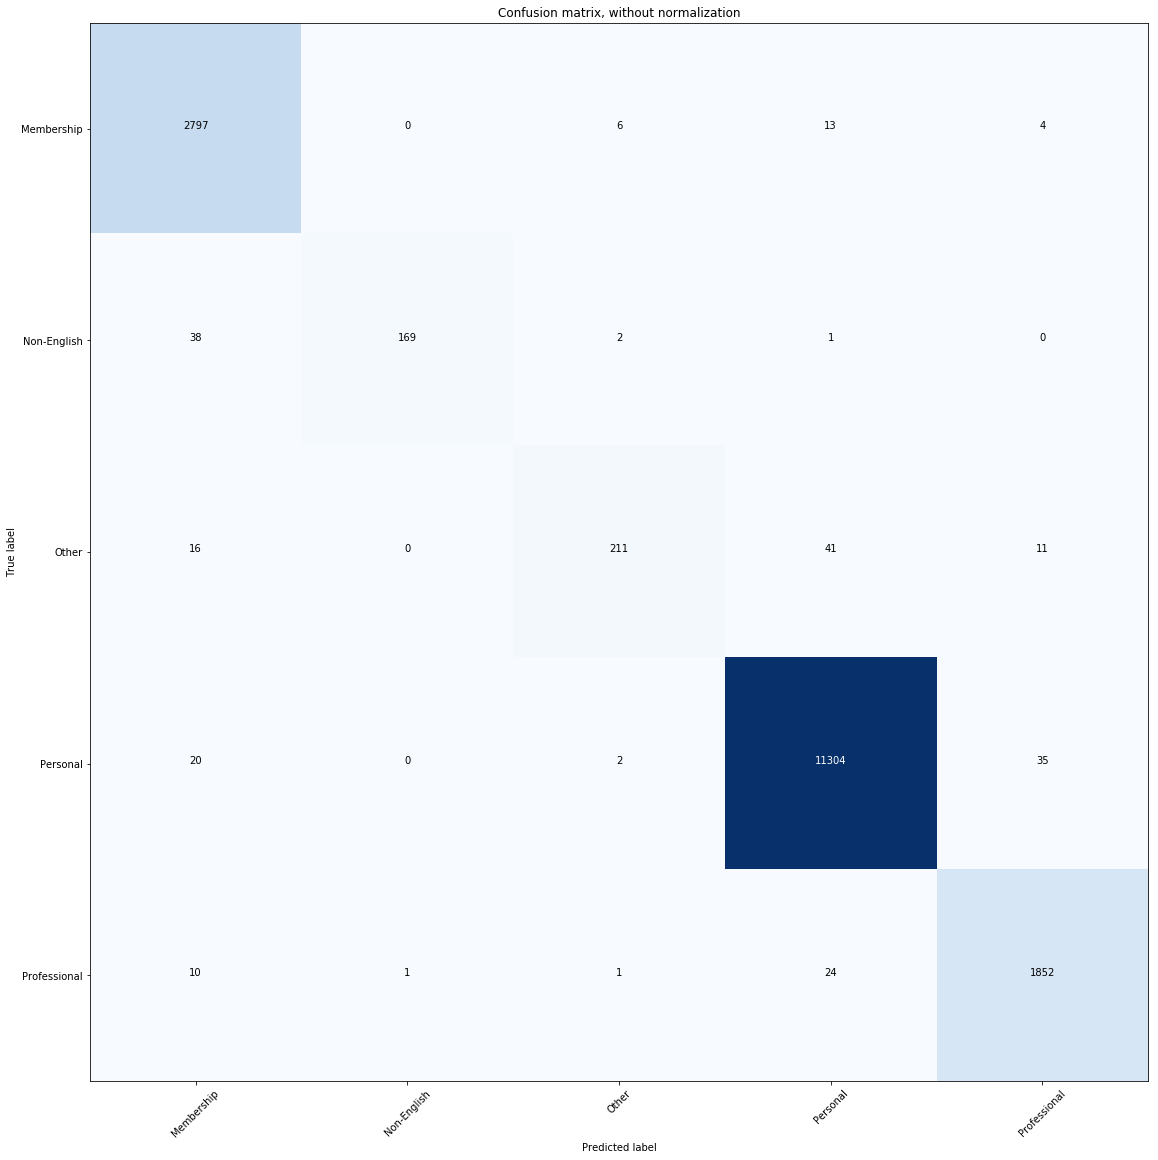

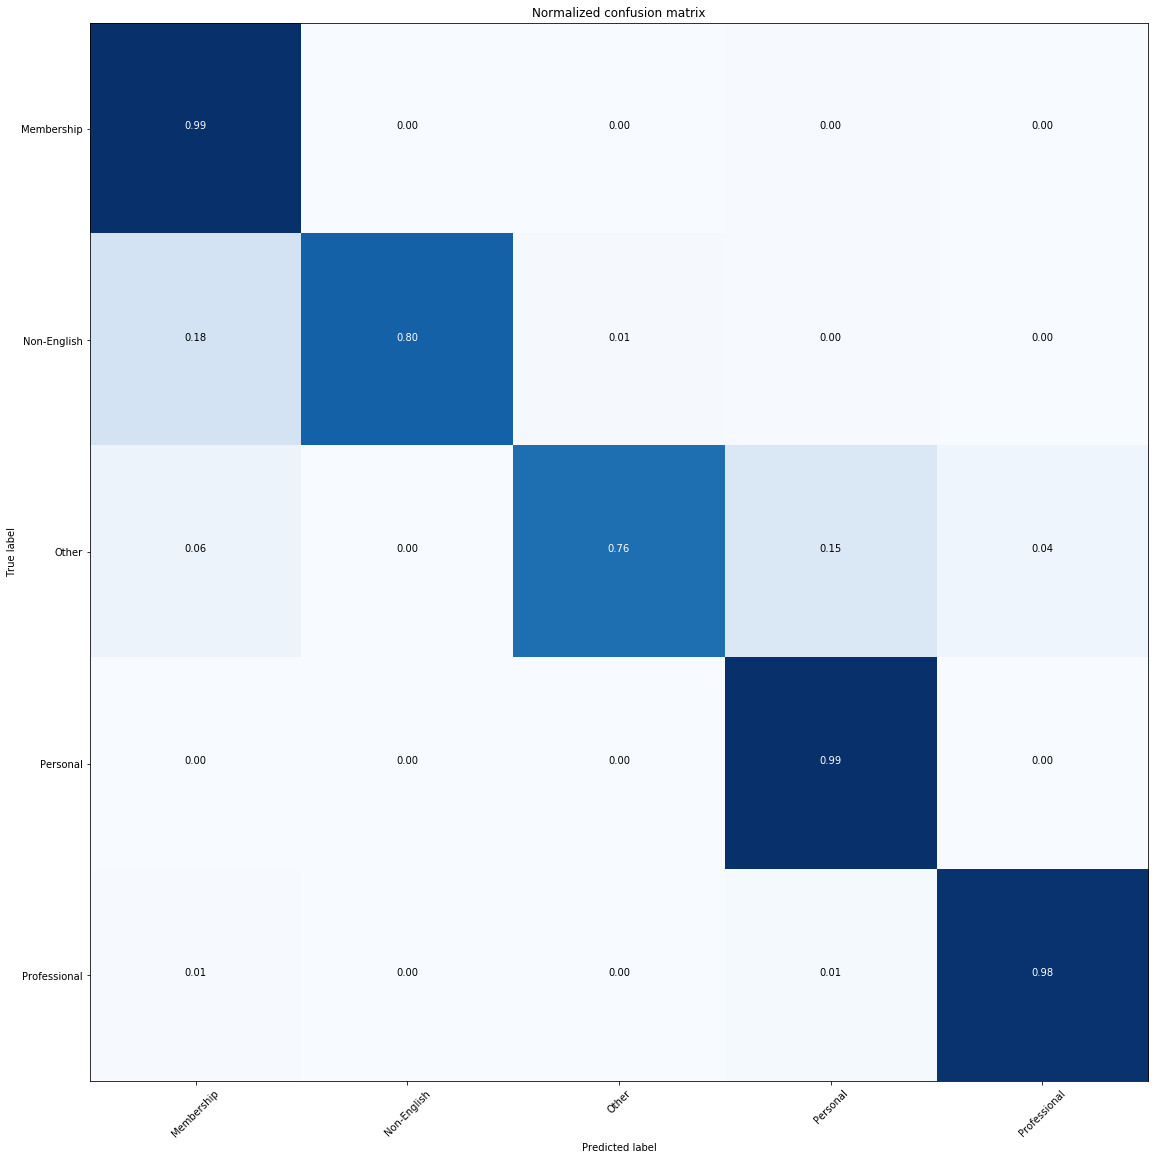

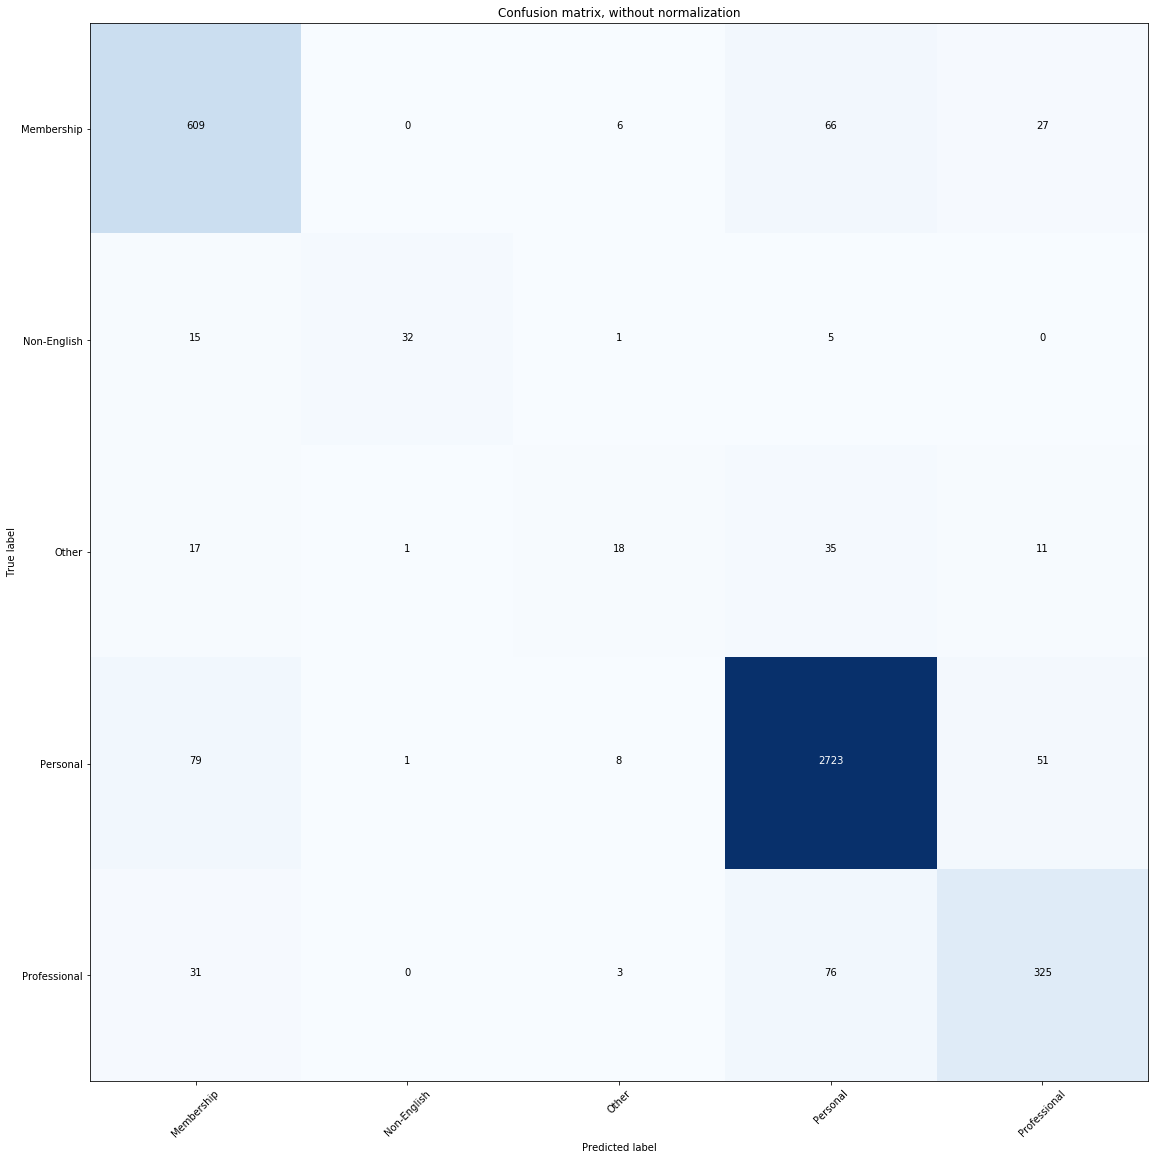

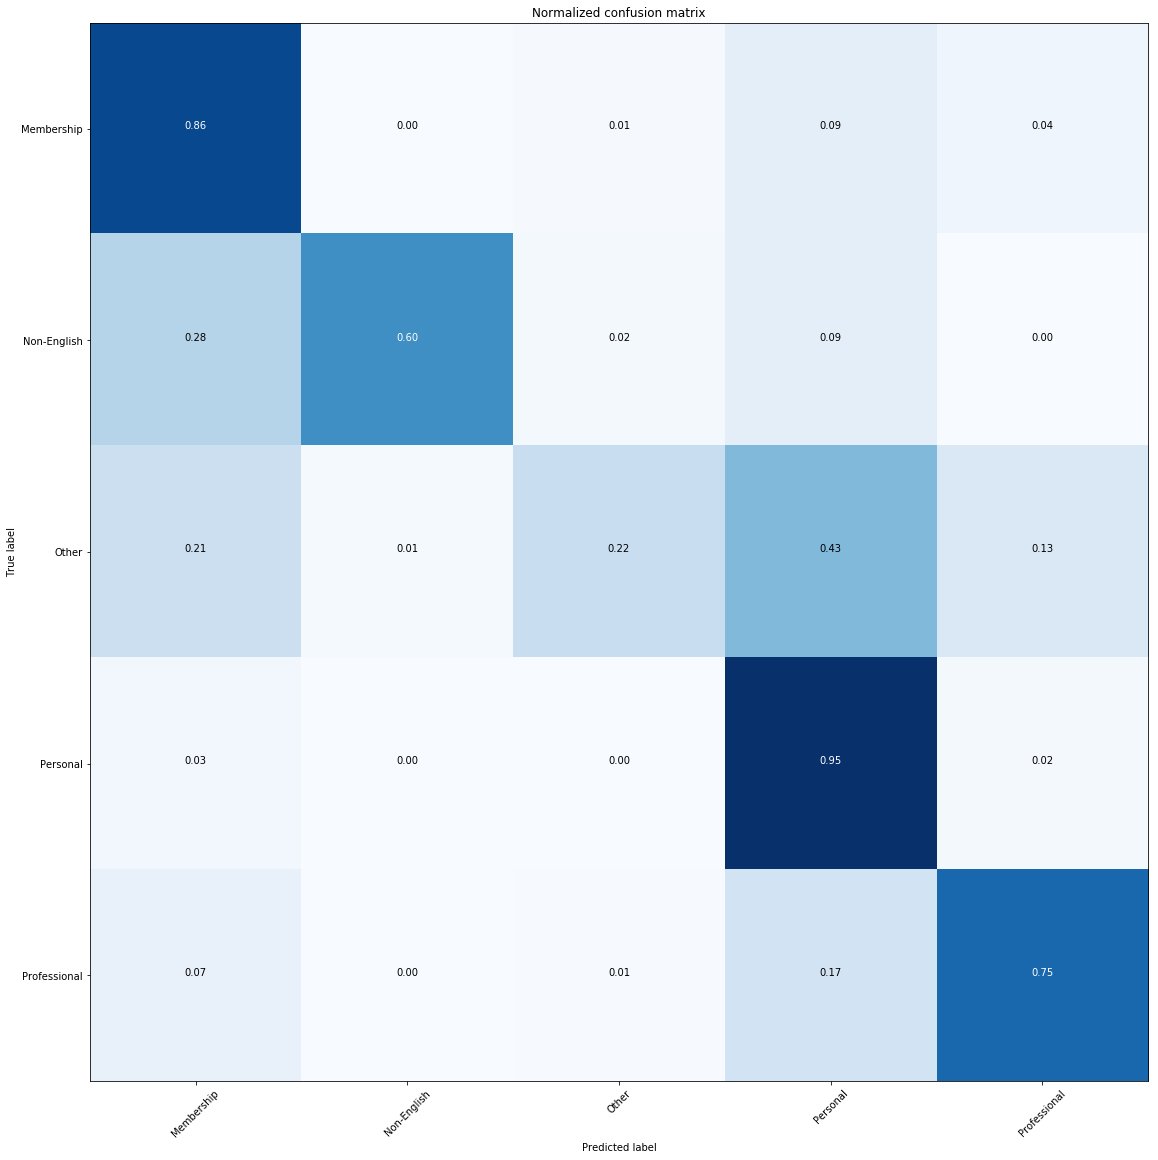

precison,recall,f_score:
micro:
(0.8954106280193237, 0.8954106280193237, 0.8954106280193237, None)
weighted:
(0.891109258156425, 0.8954106280193237, 0.8914957613435691, None)
none:
(array([0.81, 0.94, 0.5 , 0.94, 0.79]), array([0.86, 0.6 , 0.22, 0.95, 0.75]), array([0.83, 0.74, 0.31, 0.94, 0.77]), array([ 708,   53,   82, 2862,  435]))


In [21]:
model_level1=TextCat_MultiClass(dataframe=data,Cat_Var='cat_id_H',epoch=10,clss_name=data[['cat_level1','cat_id_H']].drop_duplicates().sort_values('cat_id_H').reset_index(drop=True).cat_level1)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1321800   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                27672     
Total params: 1,413,600
Trainable params: 91,800
Non-trainable params: 1,321,800
_________________________________________________________________
None
Epoch 1/15
 - 3s - loss: 1.7906 - acc: 0.5047
Epoch 2/15
 - 2s - loss: 1.0252 - acc: 0.7098
Epoch 3/15
 - 3s - loss: 0.821

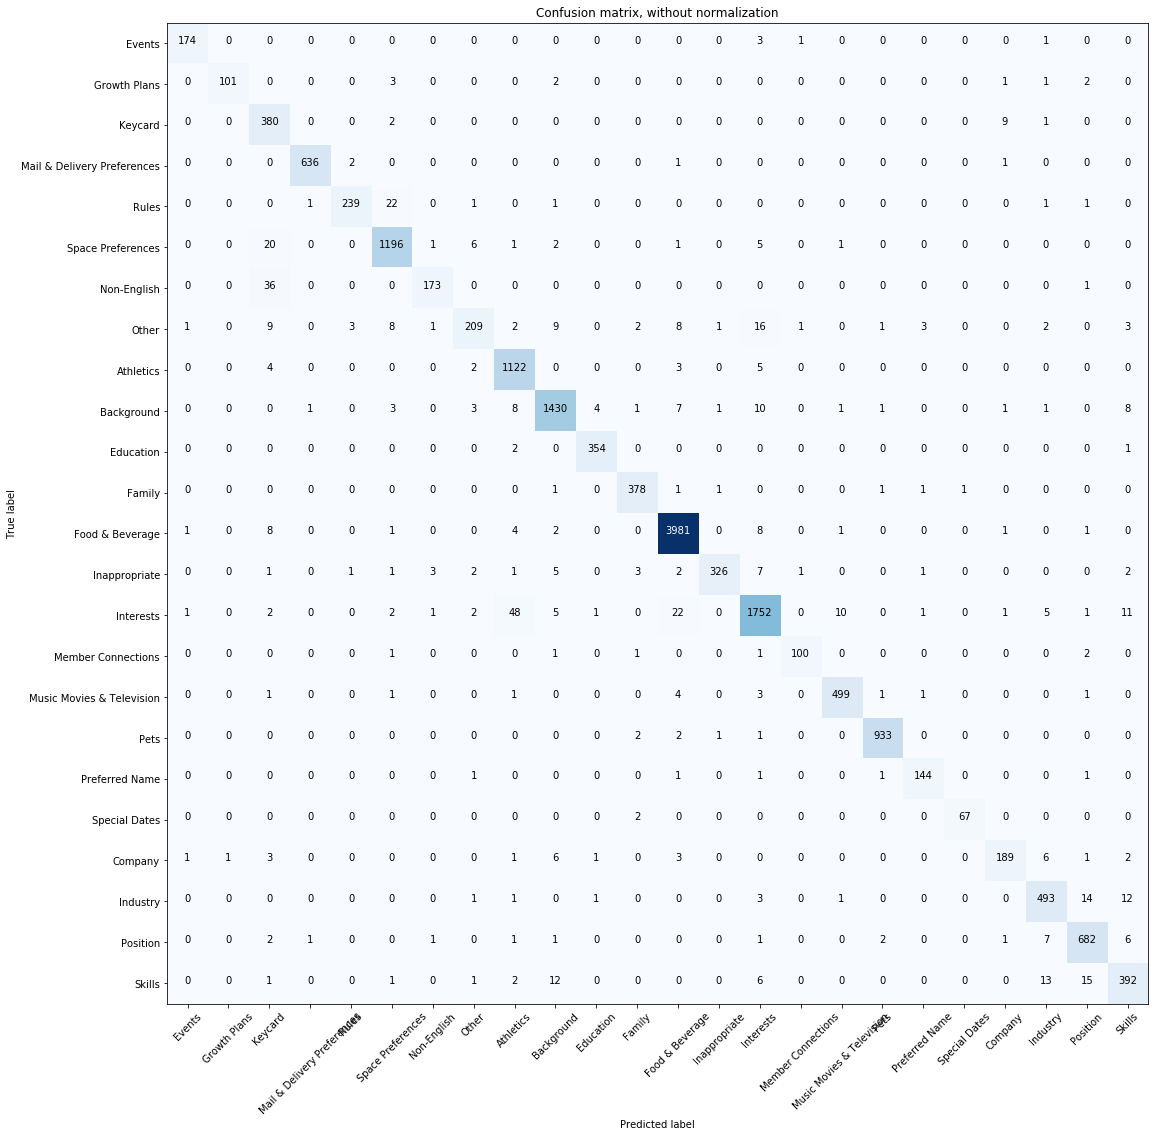

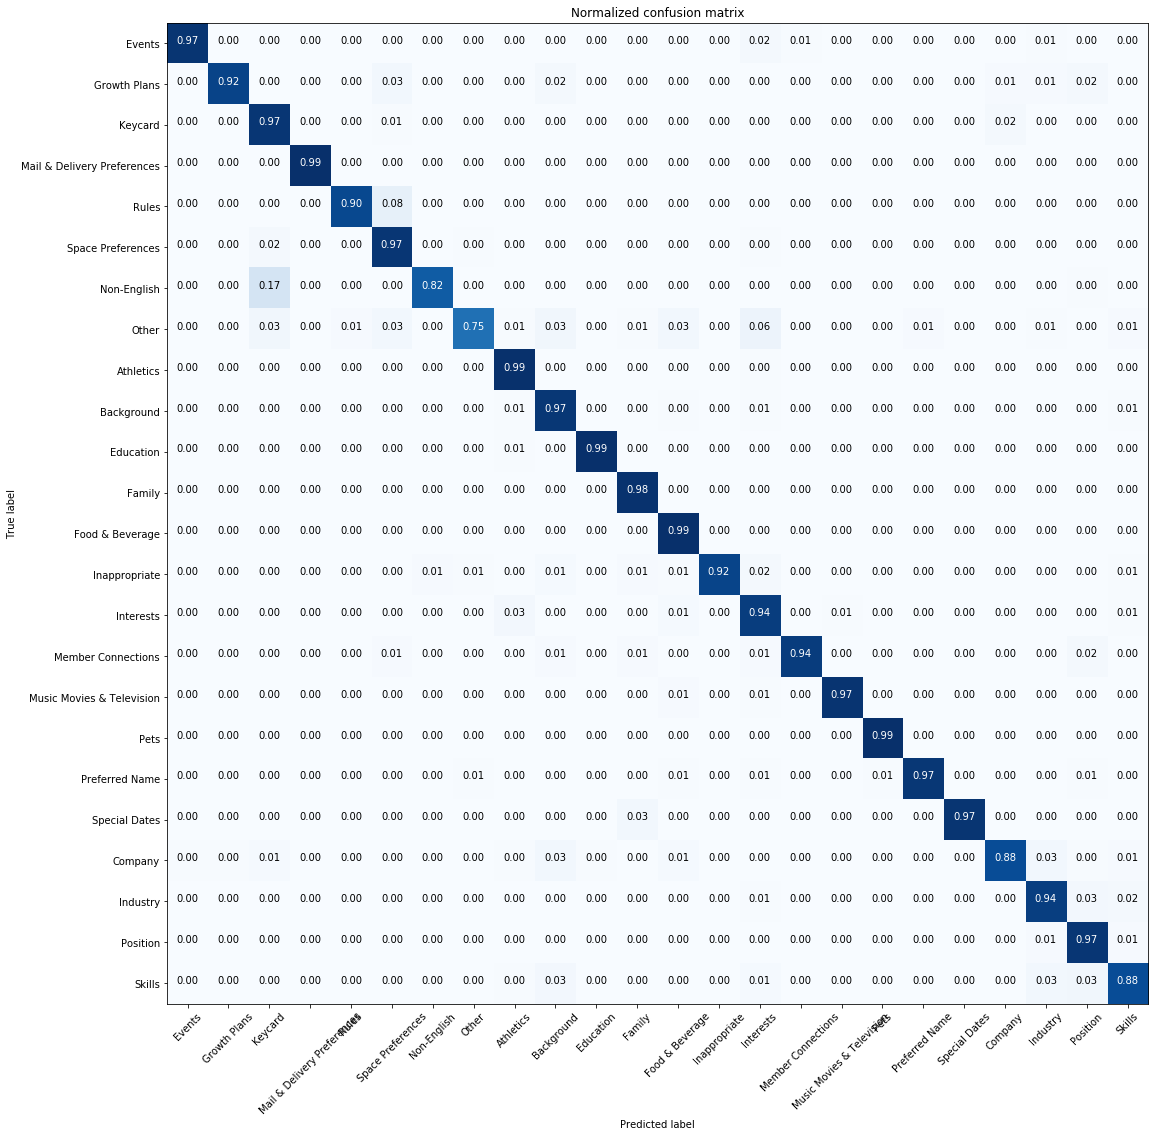

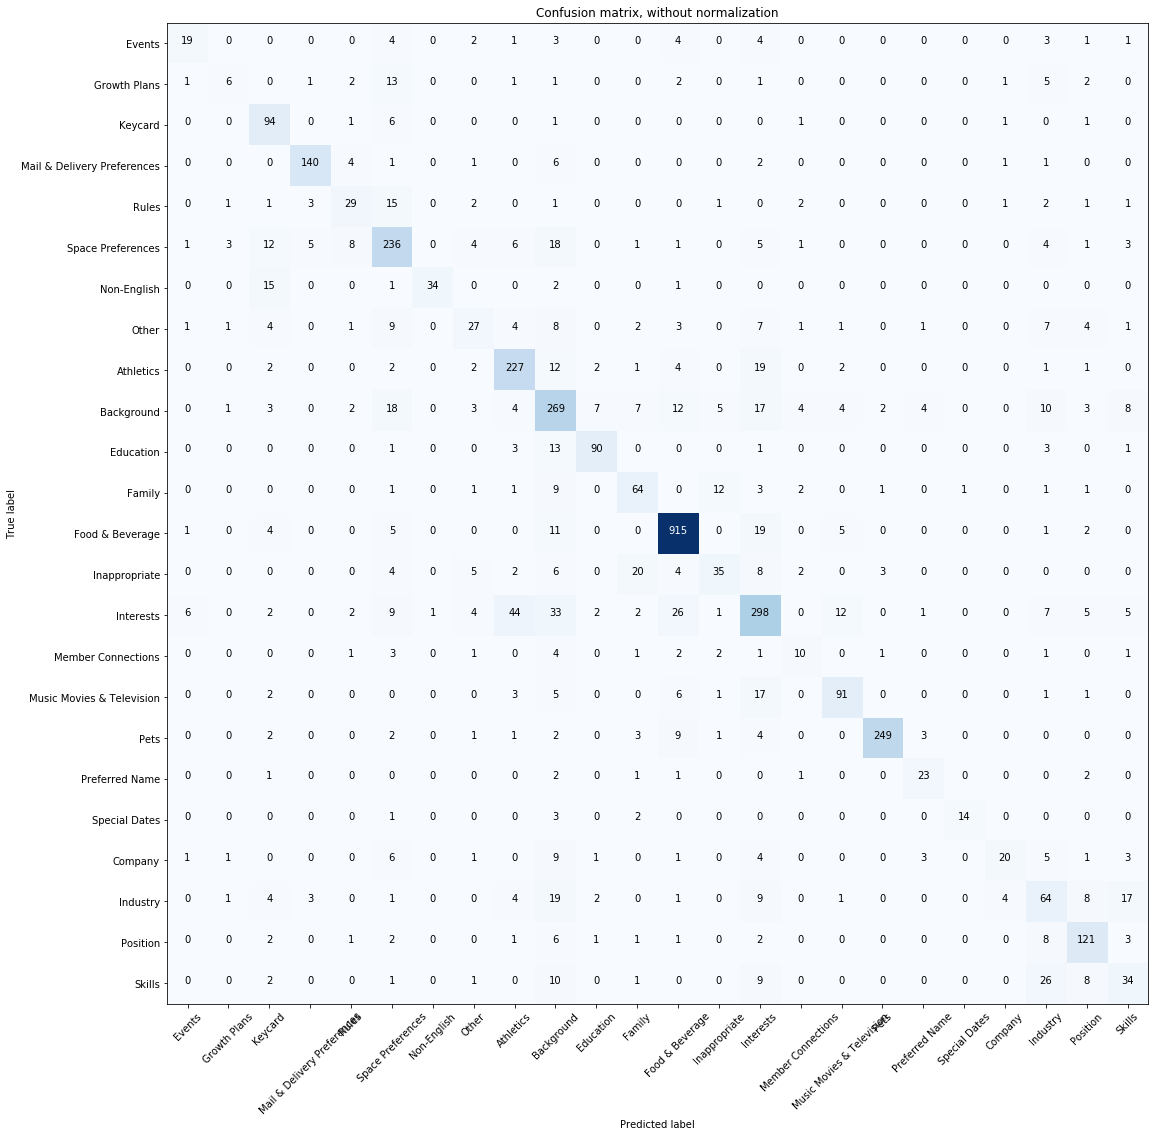

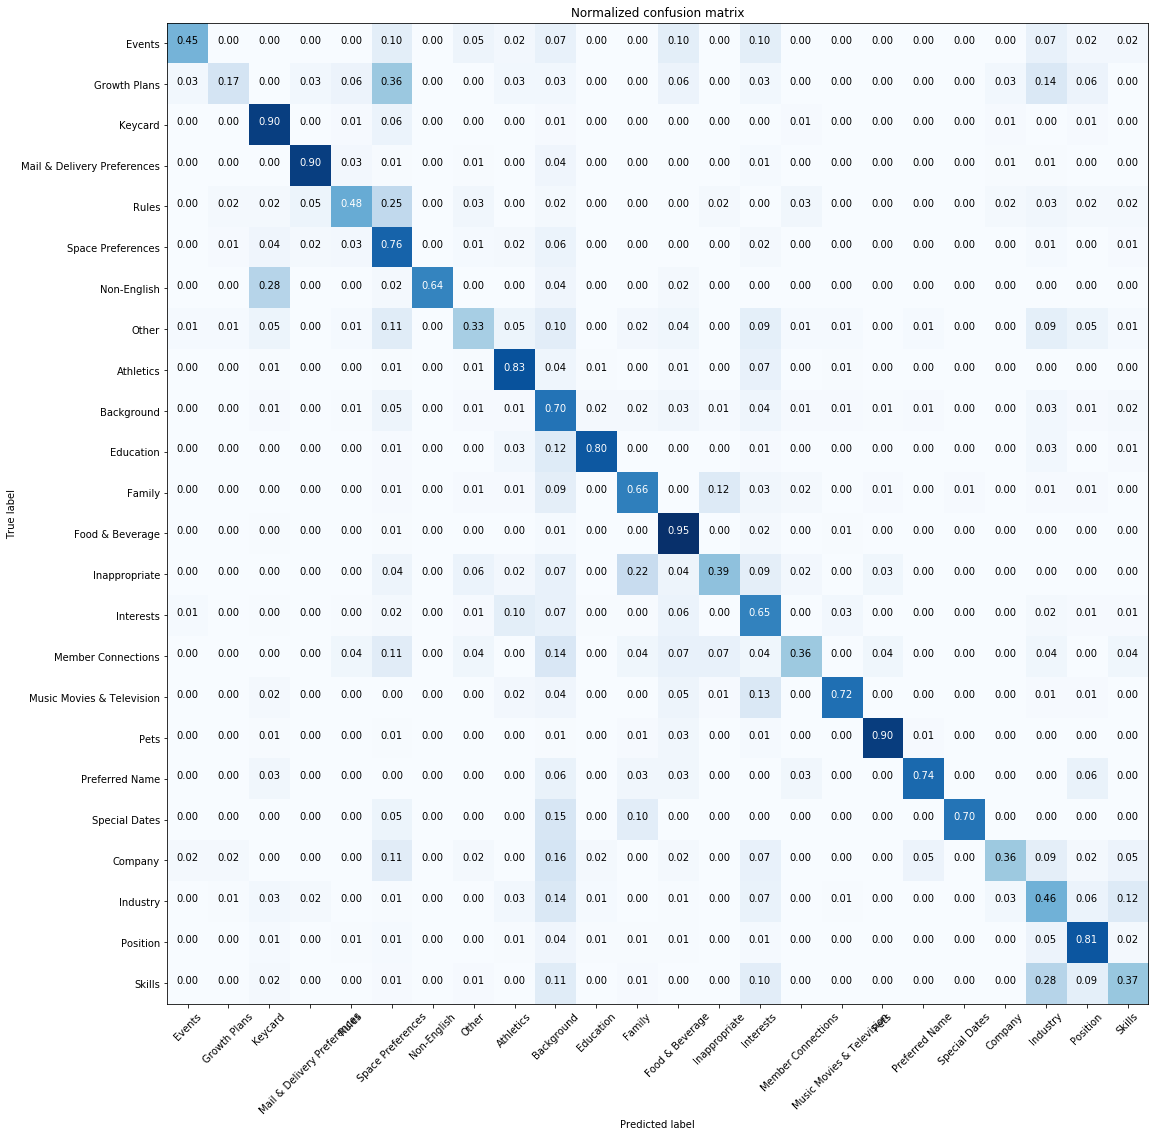

precison,recall,f_score:
micro:
(0.7509661835748792, 0.7509661835748792, 0.7509661835748792, None)
weighted:
(0.7509980524827353, 0.7509661835748792, 0.7463847108131527, None)
none:
(array([0.63, 0.43, 0.63, 0.92, 0.57, 0.69, 0.97, 0.49, 0.75, 0.59, 0.86,
       0.6 , 0.92, 0.6 , 0.69, 0.42, 0.78, 0.97, 0.66, 0.93, 0.71, 0.43,
       0.74, 0.44]), array([0.45, 0.17, 0.9 , 0.9 , 0.48, 0.76, 0.64, 0.33, 0.83, 0.7 , 0.8 ,
       0.66, 0.95, 0.39, 0.65, 0.36, 0.72, 0.9 , 0.74, 0.7 , 0.36, 0.46,
       0.81, 0.37]), array([0.53, 0.24, 0.74, 0.91, 0.52, 0.73, 0.77, 0.39, 0.79, 0.64, 0.83,
       0.63, 0.94, 0.48, 0.67, 0.38, 0.75, 0.93, 0.7 , 0.8 , 0.48, 0.44,
       0.78, 0.4 ]), array([ 42,  36, 105, 156,  60, 309,  53,  82, 275, 383, 112,  97, 963,
        89, 460,  28, 127, 277,  31,  20,  56, 138, 149,  92]))


In [22]:
model_level2=TextCat_MultiClass(dataframe=data,Cat_Var='cat_id',epoch=15,clss_name=data[['subcat','cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True).subcat)



In [282]:
#data[['subcat','cat_id','note_text']].groupby(['subcat','cat_id']).count().reset_index().sort_values(by='note_text', ascending=False)
#data[['cat_level1','cat_id_H','note_text']].groupby(['cat_level1','cat_id_H']).count().reset_index()

## output distribution for user input sentences

## Multilabel classification

### load multilabel data subset

In [23]:
print(df_mul.shape)
print(df_mul.head())

(6479, 4)
                              note_uuid created_at  \
0  713129f6-a7e0-4551-80e0-1553204de752    20:23.0   
1  d62ef03e-b509-44dc-bc9f-6fcd6838c838    18:57.3   
2  b967afb3-e105-4f12-a947-1704a554093c    26:18.0   
3  ab8b33bf-09f5-47c7-8450-5999a45c64a7    05:56.6   
4  e6e2eb5e-df16-4b99-b70a-b99bf3db2ddf    56:16.7   

                                                                 note_text  \
0  Travels the most for the company doing client relations and maintaining   
1                                 From Vancouver ! Mail & Package for Jive   
2                    fun fact: she was an extra in daddy daycare the movie   
3                                            ceo of postamo and nestigator   
4                          also works as a music manager and loves to sing   

                                                       category  
0               Personal/Member Connections,Professional/Skills  
1    Membership/Mail & Delivery Preferences,Personal/Background 

In [24]:
data_multilabel=df[['note_text','category']]
data_multilabel.shape

(27177, 2)

In [25]:
data_multilabel=df_mul[['note_text','category']]
data_multilabel.shape

(6479, 2)

In [26]:
data2=pd.merge(data_multilabel,data_multilabel['category'].str.get_dummies(sep=','),left_index=True, right_index=True)
data2['category_count']=data2.sum(axis=1)
print(data2.shape)

(6479, 26)


In [27]:
#len(data2.loc[data2.category_count>1,]) #6479

In [28]:
data2.columns

Index(['note_text', 'category', 'Membership/Events', 'Membership/Growth Plans',
       'Membership/Keycard', 'Membership/Mail & Delivery Preferences',
       'Membership/Rules', 'Membership/Space Preferences', 'Other',
       'Personal/Athletics', 'Personal/Background', 'Personal/Education',
       'Personal/Family', 'Personal/Food & Beverage', 'Personal/Inappropriate',
       'Personal/Interests', 'Personal/Member Connections',
       'Personal/Music Movies & Television', 'Personal/Pets',
       'Personal/Preferred Name', 'Personal/Special Dates',
       'Professional/Company', 'Professional/Industry',
       'Professional/Position', 'Professional/Skills', 'category_count'],
      dtype='object')

In [30]:
data2.head()

,note_text,category,Membership/Events,Membership/Growth Plans,Membership/Keycard,Membership/Mail & Delivery Preferences,Membership/Rules,Membership/Space Preferences,Other,Personal/Athletics,...,Personal/Member Connections,Personal/Music Movies & Television,Personal/Pets,Personal/Preferred Name,Personal/Special Dates,Professional/Company,Professional/Industry,Professional/Position,Professional/Skills,category_count
0,Travels the most for the company doing client relations and maintaining,"Personal/Member Connections,Professional/Skills",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
1,From Vancouver ! Mail & Package for Jive,"Membership/Mail & Delivery Preferences,Personal/Background",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,fun fact: she was an extra in daddy daycare the movie,"Professional/Position,Personal/Music Movies & Television",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,2
3,ceo of postamo and nestigator,"Professional/Position,Professional/Industry",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,2
4,also works as a music manager and loves to sing,"Professional/Industry,Professional/Skills,Personal/Interests",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3


In [34]:
selected_categories = ['Membership/Events', 'Membership/Growth Plans',
       'Membership/Keycard', 'Membership/Mail & Delivery Preferences',
       'Membership/Rules', 'Membership/Space Preferences', 'Other',
       'Personal/Athletics', 'Personal/Background', 'Personal/Education',
       'Personal/Family', 'Personal/Food & Beverage', 'Personal/Inappropriate',
       'Personal/Interests', 'Personal/Member Connections',
       'Personal/Music Movies & Television', 'Personal/Pets',
       'Personal/Preferred Name', 'Personal/Special Dates',
       'Professional/Company', 'Professional/Industry',
       'Professional/Position', 'Professional/Skills']

In [35]:
#def TextCat_Multilabel(dataframe,epoch=3):#,Cat_Var,epoch,clss_name

epoch=5
train,test  =  train_test_split(data2,test_size=0.2,random_state=7)

#print(train.head())
#print(test.head())
#labels,docs,labels_t,docs_t=load_data(Cat_Var=Cat_Var,data=dataframe,split=0.8)
docs=train.note_text
docs_t=test.note_text
labels_onehot=train.iloc[:,2:(data2.shape[1]-1)]

t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of max_length words
max_length =50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# load the whole embedding into memory
embeddings_index = load_glove_embedding()
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
model.add(e)

#model.add(Dropout(0.2))

model.add(Conv1D(128,                 #added by me
                 5,
                 padding='valid',
                 activation='relu'))

model.add(MaxPooling1D(5))     #added by me

model.add(Flatten())
category_count=labels_onehot.shape[1]

model.add(Dense(category_count, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels_onehot,batch_size=128, epochs=epoch, verbose=2# ,validation_data=(x_val, y_val)
         )
# evaluate the model
score = model.evaluate(padded_docs, labels_onehot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])


    
    
    
    
###############################################

#cnf_matrix = confusion_matrix(labels_onehot,label_train_pred)
#    cnf_matrix_t = confusion_matrix(labels_t,label_test_pred)
   # np.set_printoptions(precision=2)

#print(cnf_matrix)
# Plot non-normalized confusion matrix



Loaded 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           917700    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 23)                26519     
Total params: 1,008,347
Trainable params: 90,647
Non-trainable params: 917,700
_________________________________________________________________
None
Epoch 1/5
 - 1s - loss: 0.3335 - acc: 0.8932
Epoch 2/5
 - 1s - loss: 0.2351 - acc: 0.9133
Epoch 

In [36]:
encoded_docs_t = t.texts_to_sequences(docs_t)
padded_docs_t = pad_sequences(encoded_docs_t, maxlen=max_length, padding='post')
labels_t_onehot=test.iloc[:,2:(data2.shape[1]-1)]
score_t = model.evaluate(padded_docs_t, labels_t_onehot, verbose=0)
print('Test loss:', score_t[0])
print('Test accuracy:', score_t[1])
label_train_pred=model.predict_classes(padded_docs)
label_test_pred=model.predict_classes(padded_docs_t)

    

Test loss: 0.1884235390174536
Test accuracy: 0.9263620700365232


In [37]:

#test_multilabel_prob=model.predict(padded_docs_t)
#test_multilabel_prob=pd.DataFrame(test_multilabel_prob,columns  = selected_categories)
#test_multilabel_prob.round(0).astype(int).sum(axis=1)
#
#idxs = np.argsort(proba)[::-1][:2] # return top 2 categories

In [405]:
from sklearn.metrics import coverage_error

coverage_error(labels_onehot, model.predict(padded_docs))

5.687632645186185

In [406]:
coverage_error(labels_t_onehot, model.predict(padded_docs_t))

6.30787037037037

In [399]:
#print(docs[0])
#preds= model.predict(padded_docs)[:5]

preds = (model.predict(padded_docs) >= 0.3).astype(int)
    
    #label_train_pred=preds
#    label_test_pred=model.predict_classes(padded_docs_t)

#for i, prob in enumerate(preds):
 #   if prob > 0.2:
  #      print(selected_categories[i])
        
preds[:5]   

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]])

In [414]:
print(docs[:5])
print(labels_onehot[:5])

172                                             05-09-17 Birthday Gift - Ferrero Rocher - Jhonatan Cardoso 
4931                                                               - researcher for ecoamerica\n- from utah
1555                                                   fav holiday is thanksgiving, fav show is friends :) 
3269                     Has a passion for participating in non-profit causes! Has done cycling and running
6133    Loves ordering clothes from Rent the Runway. Currently using "Rent the Runway Unlimited" which s...
Name: note_text, dtype: object
      Membership/Events  Membership/Growth Plans  Membership/Keycard  \
172                   0                        0                   0   
4931                  0                        0                   0   
1555                  0                        0                   0   
3269                  0                        0                   0   
6133                  0                        0                   0 

In [240]:
def TextCat_Multilabel(dataframe=data2,Cat_Var,epoch,clss_name):
    train,test  =  train_test_split (data,test_size=0.2,random_state=7)
    print(train.head())
    print(test.head())
    labels,docs,labels_t,docs_t=load_data_multilabel(Cat_Var=Cat_Var,data=dataframe,split=0.8)
  
    labels_onehot=to_categorical(labels)
    
    t = Tokenizer()
    t.fit_on_texts(docs)
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(docs)
    # pad documents to a max length of max_length words
    max_length =50
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    # load the whole embedding into memory
    embeddings_index = load_glove_embedding()
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    # define model
    model = Sequential()
    e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
    model.add(e)

    #model.add(Dropout(0.2))

    model.add(Conv1D(128,                 #added by me
                     5,
                     padding='valid',
                     activation='relu'))

    model.add(MaxPooling1D(5))     #added by me

    model.add(Flatten())
    model.add(Dense(24, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    # fit the model
    model.fit(padded_docs, labels_onehot,batch_size=128, epochs=epoch, verbose=2# ,validation_data=(x_val, y_val)
             )
    # evaluate the model
    score = model.evaluate(padded_docs, labels_onehot, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #model.evaluate(mat_texts, tags, verbose=0)
    encoded_docs_t = t.texts_to_sequences(docs_t)
    padded_docs_t = pad_sequences(encoded_docs_t, maxlen=max_length, padding='post')
    labels_t_onehot=to_categorical(labels_t)
    score_t = model.evaluate(padded_docs_t, labels_t_onehot, verbose=0)
    print('Test loss:', score_t[0])
    print('Test accuracy:', score_t[1])
    label_train_pred=model.predict_classes(padded_docs)
    label_test_pred=model.predict_classes(padded_docs_t)
    

###############################################

    cnf_matrix = confusion_matrix(labels,label_train_pred)
    cnf_matrix_t = confusion_matrix(labels_t,label_test_pred)
    np.set_printoptions(precision=2)

    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix,
                          classes=clss_name,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix, 
                          classes=clss_name, normalize=True,
                      title='Normalized confusion matrix')

    
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix_t,
                          classes=clss_name,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(16,20))
    plot_confusion_matrix(cnf_matrix_t, 
                          classes=clss_name, normalize=True,
                      title='Normalized confusion matrix')
    plt.show()


#### Build a classifier optimized for maximizing f1_score (uses class_weights)

clf = Sequential()

clf.add(Dropout(0.3))
clf.add(Dense(xt.shape[1], 1600, activation='relu'))
clf.add(Dropout(0.6))
clf.add(Dense(1600, 1200, activation='relu'))
clf.add(Dropout(0.6))
clf.add(Dense(1200, 800, activation='relu'))
clf.add(Dropout(0.6))
clf.add(Dense(800, yt.shape[1], activation='sigmoid'))

clf.compile(optimizer=Adam(), loss='binary_crossentropy')

clf.fit(xt, yt, batch_size=64, nb_epoch=300, validation_data=(xs, ys), class_weight=W, verbose=0)

preds = clf.predict(xs)

preds[preds>=0.5] = 1
preds[preds<0.5] = 0

print f1_score(ys, preds, average='macro')

In [38]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_md')
matcher = Matcher(nlp.vocab)
pattern = [{'SHAPE': 'ddddddd'}]
matcher.add('KEYCARD_NUMBER', None, pattern)

doc = nlp(u"7893452")
print([t.text for t in doc])
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

['7893452']


## Backup Old

In [70]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = texts
# define class labels
labels = tags
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
#print(encoded_docs)
# pad documents to a max length of 4 words
max_length =50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
#print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
model.add(e)

#model.add(Dropout(0.2))

model.add(Conv1D(128,                 #added by me
                     5,
                     padding='valid',
                     activation='relu'))

model.add(MaxPooling1D(5))     #added by me




model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels,batch_size=128, epochs=10, verbose=0# ,validation_data=(x_val, y_val)
         )
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))



Loaded 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1025200   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1153      
Total params: 1,090,481
Trainable params: 65,281
Non-trainable params: 1,025,200
_________________________________________________________________
None
Accuracy: 98.955823


In [ ]:
#model.evaluate(mat_texts, tags, verbose=0)
score = model.evaluate(padded_docs, labels, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
encoded_docs = t.texts_to_sequences(texts_t)
padded_docs_t = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
score = model.evaluate(padded_docs_t, tags_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

In [36]:
def Find_Optimal_Cutoff(target, predicted):
    """  
    Parameters
    ----------
    target : True labels
    predicted : predicted probs
    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

from sklearn.metrics import roc_curve, auc,roc_auc_score
threshold=Find_Optimal_Cutoff(tttt['class'], tttt['prob'])
threshold

In [31]:
tttt=pd.DataFrame(model.predict(padded_docs))
tttt['prob']=pd.DataFrame(model.predict(padded_docs))

tttt['class']=labels
tttt['pred_class']=model.predict_classes(padded_docs)
print(tttt.shape)
print(tttt.head())

(11205, 4)

In [33]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(tttt['class'], tttt['pred_class'])
cnf_matrix
#plt.figure(figsize=(10,10))
#plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
#plt.show();

array([[3418,   66],
       [  61, 7660]])

In [35]:
print(3418/(3418+66))
print(7660/(7660+61))

0.9810562571756601
0.992099468980702


In [38]:
tttt['pred_class']= tttt.prob.map(lambda x: 1 if x > threshold[0] else 0)
# Print confusion Matrix
confusion_matrix(tttt['class'], tttt['pred_class'])

array([[3445,   39],
       [  88, 7633]])

In [44]:
tttt['pred_class']= tttt.prob.map(lambda x: 1 if x > threshold[0] else 0)
# Print confusion Matrix
confusion_matrix(tttt['class'], tttt['pred_class'])

array([[11268,   384],
       [  149,  3200]])

In [31]:
11450/(11450+603)
2800/(2800+148)

0.9499709615863271

0.9497964721845319

In [39]:
score = model.evaluate(padded_docs_t, tags_t, verbose=0)

In [40]:
tttt2=pd.DataFrame(model.predict(padded_docs_t))
tttt2['prob']=pd.DataFrame(model.predict(padded_docs_t))

In [41]:

# Print confusion Matrix
confusion_matrix(tags_t, tttt2.prob.map(lambda x: 1 if x > threshold[0] else 0))

array([[2649,  342],
       [ 546, 5956]])

In [ ]:
num_max =20
# preprocess
le = LabelEncoder()
tags = le.fit_transform(tags)
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(texts)
mat_texts = tok.texts_to_matrix(texts,mode='count')
print(tags[:5])
print(mat_texts[:5])
print(tags.shape,mat_texts.shape)



tags_t = le.fit_transform(tags_t)
tok_t = Tokenizer(num_words=num_max)
tok_t.fit_on_texts(texts_t)
mat_texts_t = tok_t.texts_to_matrix(texts_t,mode='count')



In [ ]:
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub.ipynb